# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [ ]:
#! pip install yfinance

In [ ]:
#!pip install pmdarima

In [118]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

import warnings
warnings.filterwarnings('ignore')

## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [119]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [120]:
samsung_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


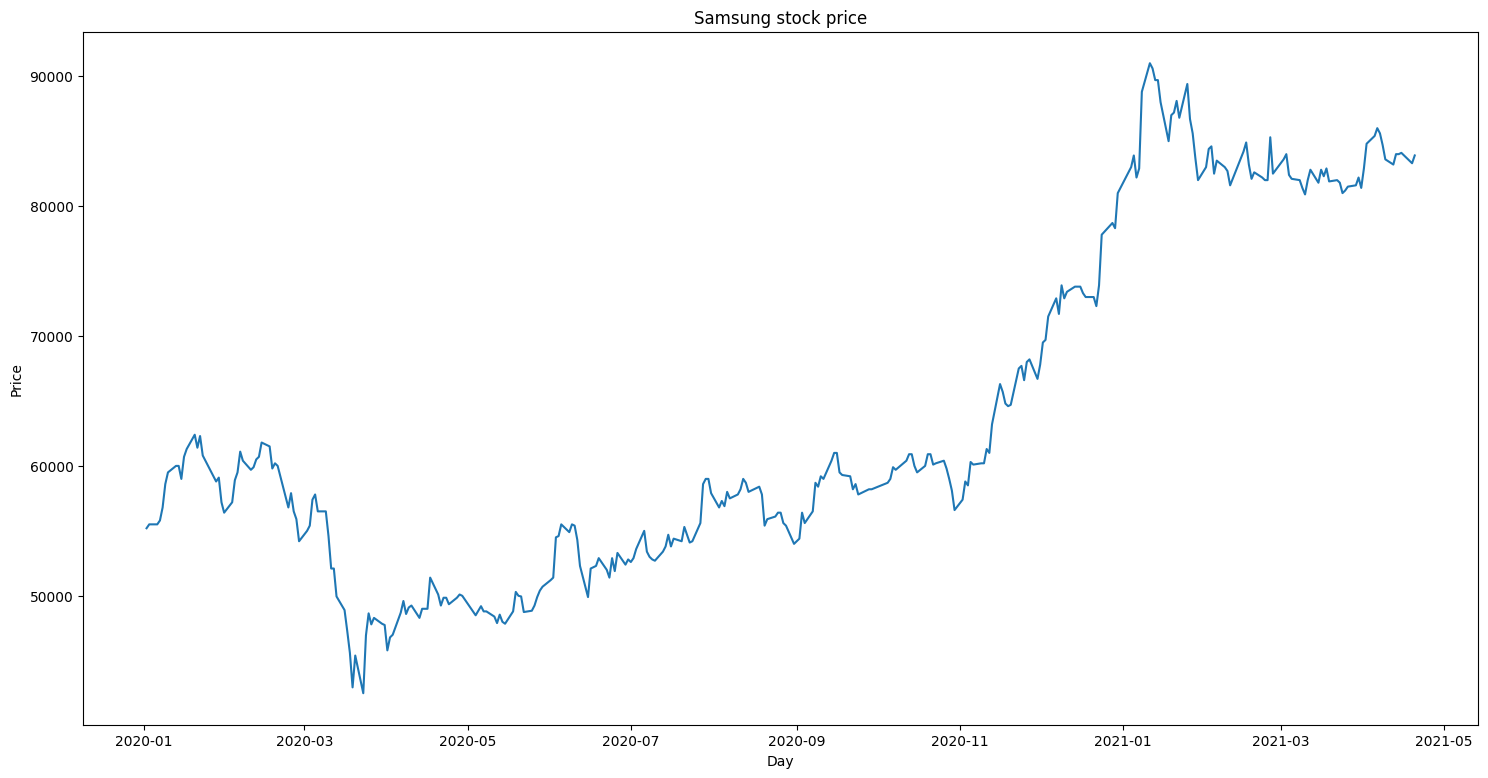

In [121]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Samsung stock price')
plt.show()

시간에 따른 평균과 분산이 일정하지 않아 비정상 시계열로 보인다.

## 시계열 분해

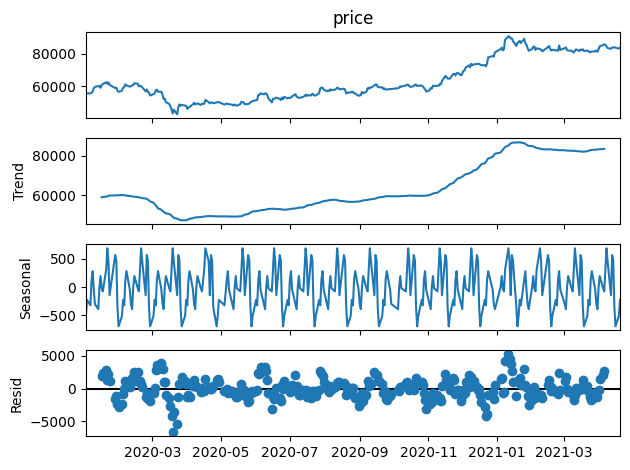

In [122]:
# 주식장은 평일에만 열리는 것을 고려하여 주기를 20일로 두고 확인
result = seasonal_decompose(samsung_df.loc[:,"price"], model='Additive', period=20)
result.plot()
plt.show()

✅ **그래프 해석**

- 하락하는 구간이 있으나, 전체적으로 증가하는 추세를 보이고 있다.
- period = 20으로 설정하였을 때, 계절성이 존재한다.
- residual : 정상성 만족 여부를 판단할 필요가 있다.


## 시계열 정상성 확인(1) - ADF

- 시계열 데이터의 정상성 여부를 판단하는 방법


- 귀무가설 H0 = 시계열에 단위근이 존재한다 (정상성을 만족하지 않는다)
- 대립가설 H1 = 시계열이 정상성을 만족한다

In [123]:
# ADF test
def adf_test(df):
    adf_result = adfuller(df.values, regression = 'ct') # 'ct' : 추세와 상수항이 모두 존재한다고 가정
    print('ADF Statistics: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('num of used lags: %f' % adf_result[2])
    print('num of obs: %f' % adf_result[3])
    for k, v in adf_result[4].items():
        print("Critical Values(%s) : %.3f" % (k,v))

print('ADF TEST 결과')
adf_test(samsung_df["price"])

ADF TEST 결과
ADF Statistics: -1.804700
p-value: 0.702487
num of used lags: 0.000000
num of obs: 321.000000
Critical Values(1%) : -3.987
Critical Values(5%) : -3.424
Critical Values(10%) : -3.135


✅ **ADF 결과해석**
- p-value > 0.05 이므로 귀무가설을 기각하지 않는다. 따라서, 삼성 주가 데이터는 비정상 시계열이다.

## 시계열 정상성 확인(2) - KPSS

- 시계열 데이터의 정상성 여부를 판단하는 방법


- 귀무가설 H0 = 시계열 과정이 정상적이다
- 대립가설 H1 = 시계열 과정이 비정상적이다

In [124]:
def kpss_test(df):
    kpss_result = kpss(df.values, regression = 'ct') # 'ct' : 추세와 상수항이 모두 존재한다고 가정
    print('KPSS Statistics: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])
    print('num of used lags: %f' % kpss_result[2])
    for k, v in kpss_result[3].items():
        print("Critical Values(%s) : %.3f" % (k,v))

print('KPSS TEST 결과')
kpss_test(samsung_df)

KPSS TEST 결과
KPSS Statistics: 0.498609
p-value: 0.010000
num of used lags: 11.000000
Critical Values(10%) : 0.119
Critical Values(5%) : 0.146
Critical Values(2.5%) : 0.176
Critical Values(1%) : 0.216


✅ **KPSS 결과해석**
- p-value < 0.01 이므로 귀무가설을 기각한다. 따라서, 삼성 주가 데이터는 비정상 시계열이다.

➡️ ADF와 KPSS 두 검정 결과를 통해 삼성 주가 데이터는 비정상성 시계열로 나타난다.
이는 대개 추세 또는 계절성을 보이거나 분산이 일정하지 않다.
따라서, 정상성을 회복하기 위한 과정으로 차분을 이용하고자 한다,

## 차분 결정

In [125]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(samsung_df, test_size = 0.1, shuffle = False)
train.shape, test.shape

((289, 1), (33, 1))

### ACF, PACF Plot

In [126]:
diff_1 = train.diff().dropna()
diff_1.head()

,price
day,
2020-01-03,300.0
2020-01-06,0.0
2020-01-07,300.0
2020-01-08,1000.0
2020-01-09,1800.0


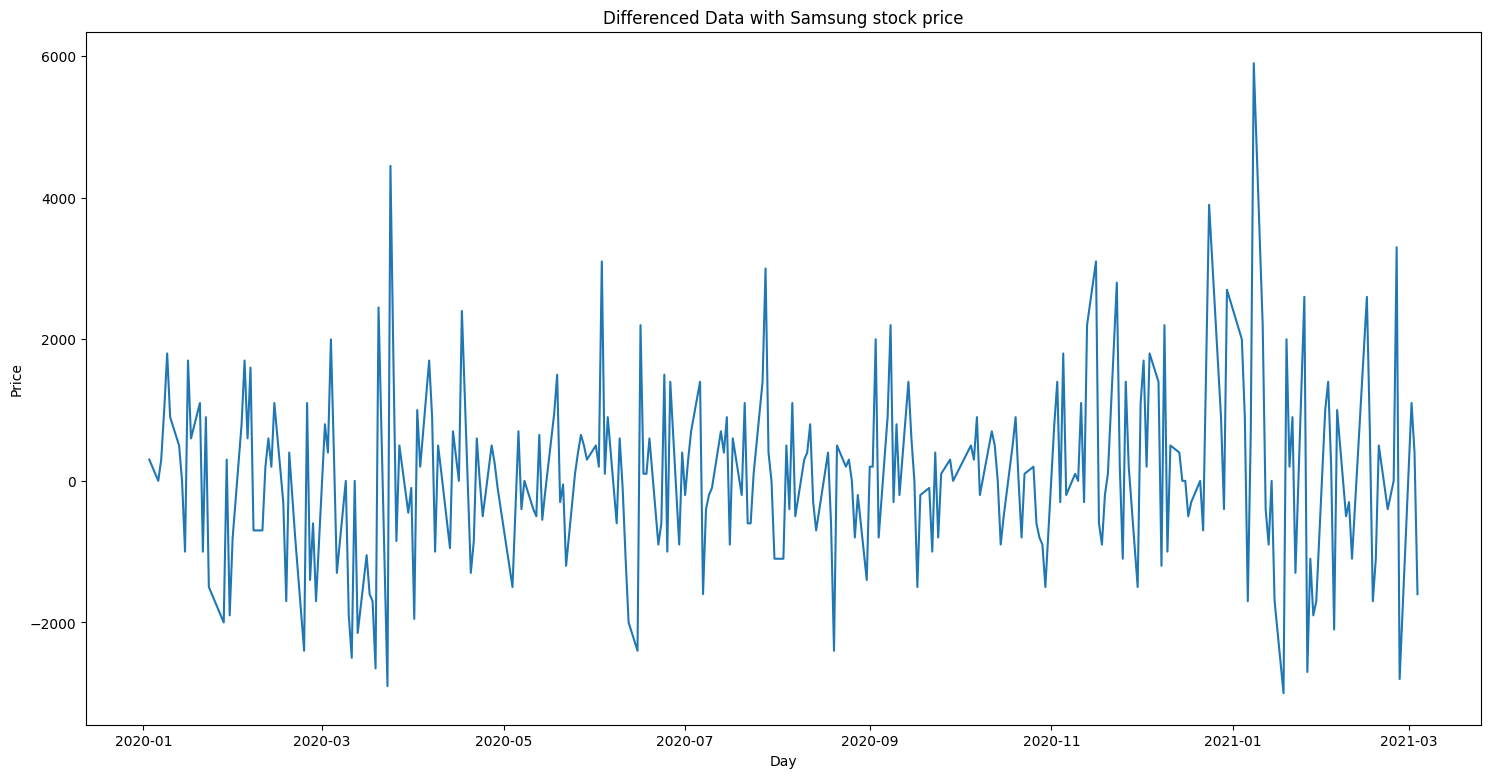

In [127]:
# 차분 데이터 그래프 확인
plt.figure(figsize=(18,9))
plt.plot(diff_1.index, diff_1["price"], linestyle="-")
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Differenced Data with Samsung stock price')
plt.show()

In [128]:
# 1차 차분 데이터 ADF 검정
adf_test(diff_1)

ADF Statistics: -16.739353
p-value: 0.000000
num of used lags: 0.000000
num of obs: 287.000000
Critical Values(1%) : -3.991
Critical Values(5%) : -3.426
Critical Values(10%) : -3.136


✅ **1차 차분 데이터 - ADF 결과해석**
- p-value < 0.05 이므로 귀무가설을 기각한다. 따라서, 1차 차분 데이터는 정상성을 만족한다.

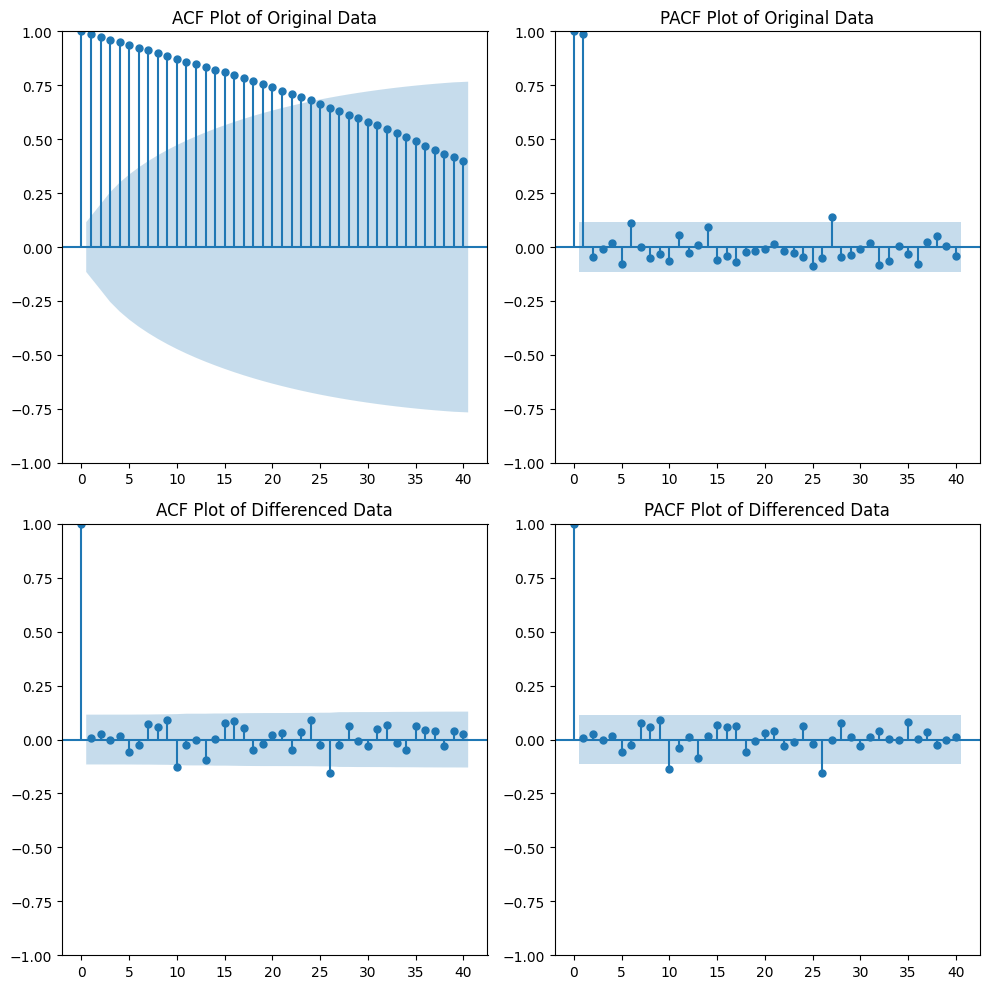

In [129]:
# train data, 1차 차분 데이터 ACF, pACF plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_acf(train['price'], lags=40, ax=ax[0, 0])
ax[0, 0].set_title('ACF Plot of Original Data')

plot_pacf(train['price'], lags=40, ax=ax[0, 1])
ax[0, 1].set_title('PACF Plot of Original Data')

plot_acf(diff_1, lags=40, ax=ax[1, 0])
ax[1, 0].set_title('ACF Plot of Differenced Data')

plot_pacf(diff_1, lags=40, ax=ax[1, 1])
ax[1, 1].set_title('PACF Plot of Differenced Data')
plt.tight_layout()
plt.show()

✅ **그래프 해석**
- Raw Data
    - ACF Plot : 시차가 증가함에 따라 자기 상관이 천천히 감소한다
    - PACF Plot : lag = 0을 제외하고 lag = 1일 때의 상관성만 높게 나타난다.
- 1차 차분한 데이터
    - 자기 상관성이 사라진다.

## 추정 및 진단

In [155]:
# seasonal = True
model = auto_arima(train['price'],
                   d = 1,
                   D = 1,
                   m = 20,
                   start_p = 0,
                   max_p = 3,
                   start_q = 0,
                   max_q = 3,
                   stepwise = True,
                   seasonal = True,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[20]             : AIC=4721.168, Time=4.05 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=4769.249, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=4748.182, Time=0.72 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=4736.378, Time=3.31 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=4734.483, Time=4.57 sec
 ARIMA(0,1,0)(1,1,0)[20]             : AIC=4746.640, Time=1.44 sec
 ARIMA(0,1,0)(2,1,1)[20]             : AIC=4723.045, Time=28.91 sec
 ARIMA(0,1,0)(1,1,2)[20]             : AIC=4723.067, Time=13.05 sec
 ARIMA(0,1,0)(0,1,2)[20]             : AIC=4724.966, Time=2.90 sec
 ARIMA(0,1,0)(2,1,0)[20]             : AIC=4735.981, Time=7.67 sec
 ARIMA(0,1,0)(2,1,2)[20]             : AIC=inf, Time=16.44 sec
 ARIMA(1,1,0)(1,1,1)[20]             : AIC=4729.795, Time=1.68 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=4730.088, Time=1.90 sec
 ARIMA(1,1,1)(1,1,1)[20]             : AIC=4731.724, Time=3.62 sec
 ARIMA(0,1,0)(1,1,1)[

In [83]:
# seasonal = False
model2 = auto_arima(train['price'],
                   d = 1,
                   D = 1,
                   m = 20,
                   start_p = 0,
                   max_p = 3,
                   start_q = 0,
                   max_q = 3,
                   stepwise = True,
                   seasonal = False,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4935.053, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4937.005, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4937.025, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4934.658, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4939.023, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds


- 계절성 반영한 경우 (SARIMA) m = 30
    -  ARIMA(0,1,0)(1,1,1)[20]            : AIC=4721.168
- 계절성 반영하지 않은 경우 (ARIMA)
    - ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4935.053

➡️ AIC 값이 낮은 모델을 최종 모델로 선정한다

In [138]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  289
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 20)   Log Likelihood               -2357.584
Date:                              Tue, 27 Feb 2024   AIC                           4721.168
Time:                                      13:40:44   BIC                           4731.941
Sample:                                           0   HQIC                          4725.495
                                              - 289                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L20       0.4357      0.042     10.364      0.000       0.353       0.518
ma.S.L20      -0.80

- **적합도**
    - Log Likelihood : -2357.584
    - AIC : 4721.168
    - BIC : 4731.941
- **통계적 검정**
    - Ljung-Box (Prob(Q) = 0.87 > p-value) : 귀무가설 채택. H0 = 잔차가 독립적이다
    - Jarque-Bera (Prob(JB) = 0.59 > p-value) : 귀무가설 채택. H0 = 잔차가 정규분포를 따른다
    - Heteroskedasticity (Prob(H) = 0.00 > p-value): 귀무가설 채택. 잔차가 등분산성을 가진다

✅ 추가 설명
- 주식장은 평일에만 열리는 것을 고려하여 주기를 20일로 간주하여 SARIMA (m=20)으로 설정하였다. AIC 값에 따라, 최종 모델로 선정하였으나, 잔차가 이분산성을 가지는 것을 확인하였다.
- ARIMA 모델 추정 결과도 확인하였으나, 이 역시 잔차가 이분산성을 가졌다.
- 이상치 검토, 모델 구조 변경 등 잔차가 등분산성을 가질 수 있도록 개선 방안을 검토할 필요성이 있다

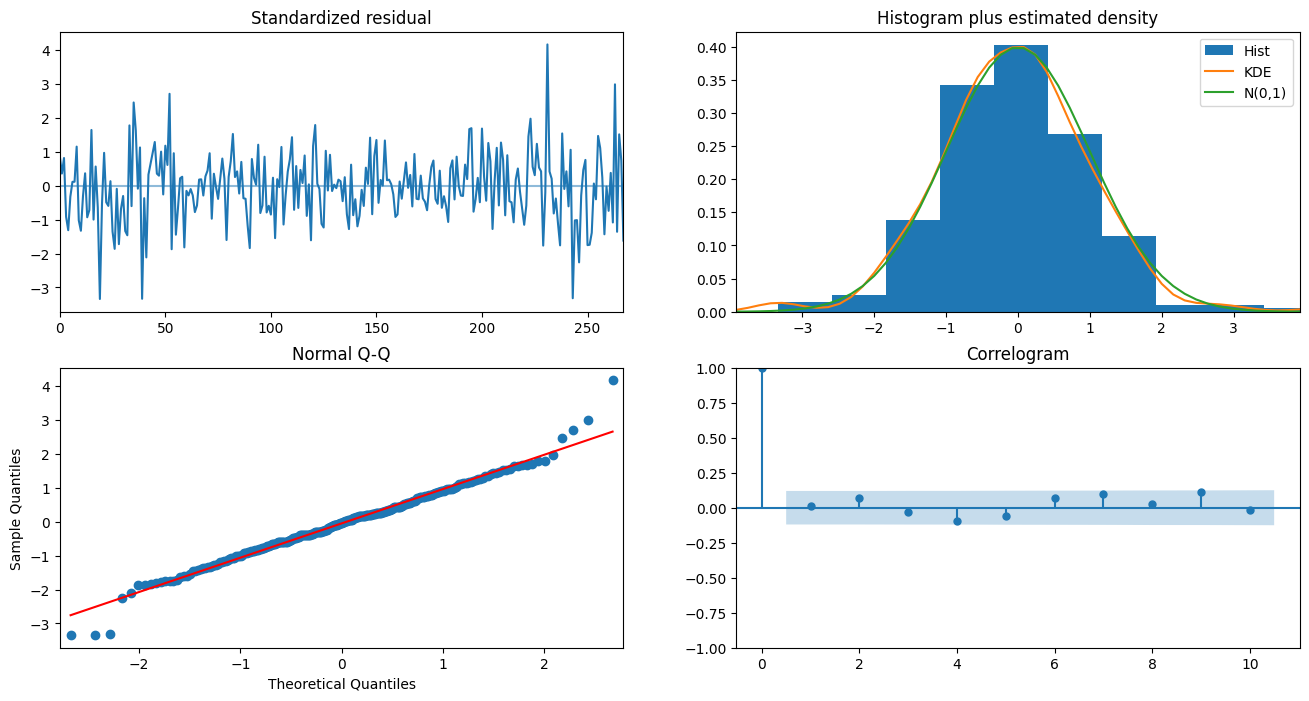

In [139]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

## 예측

In [140]:
result = model.fit(train['price'])
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast.values, columns=['predicted_price'], index=test.index)
forecast.head()

,predicted_price
day,
2021-03-05,83424.239500
2021-03-08,83484.656622
2021-03-09,82376.793571
2021-03-10,83440.187964
2021-03-11,83514.183089


In [141]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test, forecast)

2758470.8987642266

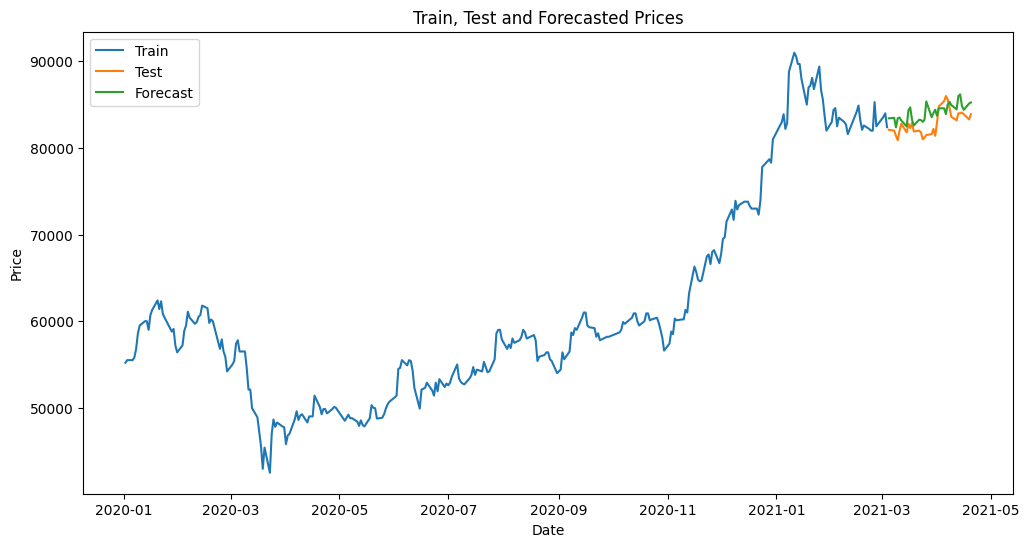

In [148]:
plt.figure(figsize=(12, 6))

plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(forecast['predicted_price'], label='Forecast')
plt.title('Train, Test and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [175]:
# 아래 링크참조하여 모델 업데이트 시도
model = auto_arima(train, d=1, D=1, m=20, start_p=0, max_p=3, start_q=0, max_q=3, stepwise=True, seasonal=True)

def forecast_one_step():
    fc, conf_int = model.predict(step=1, return_conf_int=True)
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['price']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test, forecasts)}")

Mean squared error: 1176578.7907476393


In [181]:
test_copy = test.copy()
test_copy['pred'] = forecasts

In [184]:
test_copy.head()

,price,pred
day,,
2021-03-05,82100.0,83424.239500
2021-03-08,82000.0,82159.728471
2021-03-09,81400.0,80893.599667
2021-03-10,80900.0,82458.782234
2021-03-11,82000.0,80963.746822


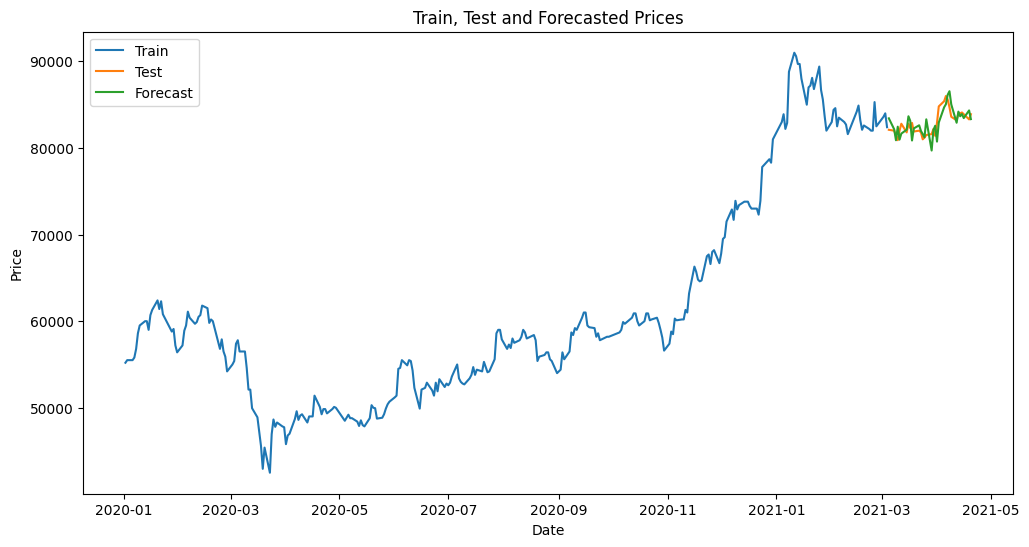

In [185]:
plt.figure(figsize=(12, 6))

plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(test_copy['pred'], label='Forecast')
plt.title('Train, Test and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


- 모델 업데이트 부분 참조 : https://velog.io/@dankj1991/time-series-3-ARIMA